# Insurance Prediction Challenge

## Context

https://zindi.africa/competitions/insurance-prediction-challenge

## Importation des modules

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# models
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# tuning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
# encoding
from sklearn.preprocessing import OrdinalEncoder
# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
# metrics
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
# utils
import random
from datetime import datetime as dt
import joblib

In [2]:
# Set seed for reproducability
SEED = 12
random.seed(SEED)
np.random.seed(SEED)

## Chargement des jeux de données

In [3]:
DATA_PATH = 'data/'
train = pd.read_csv(DATA_PATH + 'train_data.csv')
test = pd.read_csv(DATA_PATH + 'test_data.csv')
sample_submission = pd.read_csv(DATA_PATH + 'SampleSubmission.csv')
variable_description = pd.read_csv(DATA_PATH + 'VariableDescription.csv')

In [4]:
train.head(3)

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0


In [5]:
test.head(3)

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code
0,H11920,2013,1.000000,0,V,N,O,R,300.0,1,1960.0,3,3310
1,H11921,2016,0.997268,0,V,N,O,R,300.0,1,1960.0,3,3310
2,H9805,2013,0.369863,0,V,V,V,U,790.0,1,1960.0,.,3310


In [6]:
ID = 'Customer Id'
TARGET = 'Claim'

## EDA

Features description

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.2+ KB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3069 entries, 0 to 3068
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         3069 non-null   object 
 1   YearOfObservation   3069 non-null   int64  
 2   Insured_Period      3069 non-null   float64
 3   Residential         3069 non-null   int64  
 4   Building_Painted    3069 non-null   object 
 5   Building_Fenced     3069 non-null   object 
 6   Garden              3065 non-null   object 
 7   Settlement          3069 non-null   object 
 8   Building Dimension  3056 non-null   float64
 9   Building_Type       3069 non-null   int64  
 10  Date_of_Occupancy   2341 non-null   float64
 11  NumberOfWindows     3069 non-null   object 
 12  Geo_Code            3056 non-null   object 
dtypes: float64(3), int64(3), object(7)
memory usage: 311.8+ KB


Train and test set ratio

In [11]:
# proportion de l'ensemble de test par rapport à l'ensemble d'apprentissage 
test.shape[0] * 100 / (train.shape[0] + test.shape[0])

30.00293283800958

In [12]:
for colonne in list(train.columns):
    print(colonne)
    print(train[colonne].value_counts(), '\n')

Customer Id
H14663    1
H19182    1
H1571     1
H15027    1
H15026    1
         ..
H5025     1
H19098    1
H16571    1
H16570    1
H7470     1
Name: Customer Id, Length: 7160, dtype: int64 

YearOfObservation
2012    1858
2013    1811
2014    1373
2015    1075
2016    1043
Name: YearOfObservation, dtype: int64 

Insured_Period
1.000000    5325
0.997268     547
0.000000     165
0.747945      60
0.495890      49
            ... 
0.435616       1
0.308743       1
0.437158       1
0.578082       1
0.030137       1
Name: Insured_Period, Length: 401, dtype: int64 

Residential
0    4973
1    2187
Name: Residential, dtype: int64 

Building_Painted
V    5382
N    1778
Name: Building_Painted, dtype: int64 

Building_Fenced
N    3608
V    3552
Name: Building_Fenced, dtype: int64 

Garden
O    3602
V    3551
Name: Garden, dtype: int64 

Settlement
R    3610
U    3550
Name: Settlement, dtype: int64 

Building Dimension
400.0     150
500.0     120
300.0     118
450.0     117
600.0     114
        

Analyse des variables qualitatives

In [13]:
train.select_dtypes(include='object').describe()

,Customer Id,Building_Painted,Building_Fenced,Garden,Settlement,NumberOfWindows,Geo_Code
count,7160,7160,7160,7153,7160,7160,7058
unique,7160,2,2,2,2,11,1307
top,H14663,V,N,O,R,.,6088
freq,1,5382,3608,3602,3610,3551,143


Analyse des variables quantitatives

In [14]:
train.select_dtypes(include='number').describe().round(2)

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,7160.00,7160.00,7160.00,7054.00,7160.00,6652.00,7160.00
mean,2013.67,0.91,0.31,1883.73,2.19,1964.46,0.23
std,1.38,0.24,0.46,2278.16,0.94,36.00,0.42
min,2012.00,0.00,0.00,1.00,1.00,1545.00,0.00
25%,2012.00,1.00,0.00,528.00,2.00,1960.00,0.00
50%,2013.00,1.00,0.00,1083.00,2.00,1970.00,0.00
75%,2015.00,1.00,1.00,2289.75,3.00,1980.00,0.00
max,2016.00,1.00,1.00,20940.00,4.00,2016.00,1.00


> - La colonne `Customer Id` ne contient que des éléments uniques. Elle ne sera pas utile à notre apprentissage. <br>
> - La colonne `NumberOfWindows` contient des chiffres de 1 à 9 et deux valeurs spéciales : un point (.) et une description mathématique (>=10). Ce qui a fait de cette colonne une variable _object_. Pour un apprentissage correct, nous transformerons ces deux valeurs spéciales en chiffres, soit 0 et 10 respectivement. <br>
> - La colonne `Geo_Code` a l'air de ne contenir que des nombres mais il s'avère qu'elle est de type _object_.

Analyse des données manquantes

In [15]:
train.isnull().sum() / train.shape[0] * 100

Customer Id           0.000000
YearOfObservation     0.000000
Insured_Period        0.000000
Residential           0.000000
Building_Painted      0.000000
Building_Fenced       0.000000
Garden                0.097765
Settlement            0.000000
Building Dimension    1.480447
Building_Type         0.000000
Date_of_Occupancy     7.094972
NumberOfWindows       0.000000
Geo_Code              1.424581
Claim                 0.000000
dtype: float64

<Axes: xlabel='Building Dimension'>

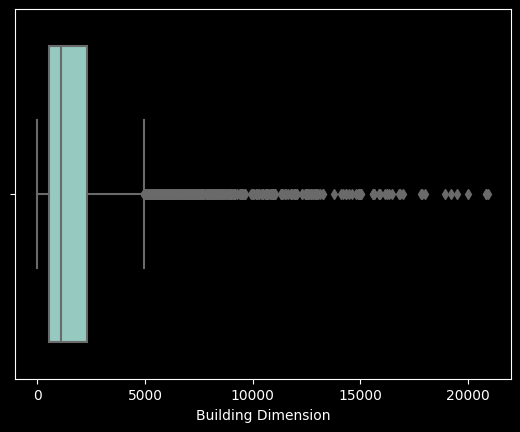

In [16]:
# Checking distribution to help decide the imputation method to use for the continous variables
sns.boxplot(x=train['Building Dimension'])

<Axes: xlabel='Date_of_Occupancy'>

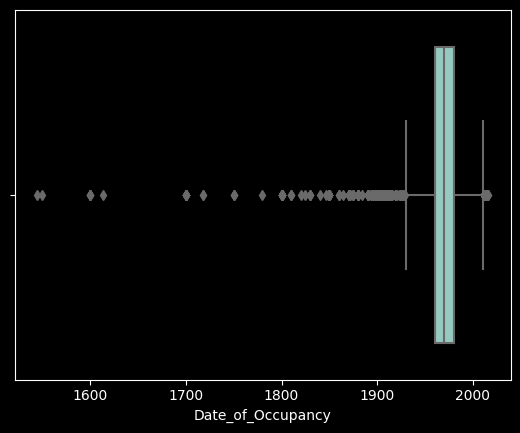

In [17]:
sns.boxplot(x=train['Date_of_Occupancy'])

Analyse et visualisation de la target

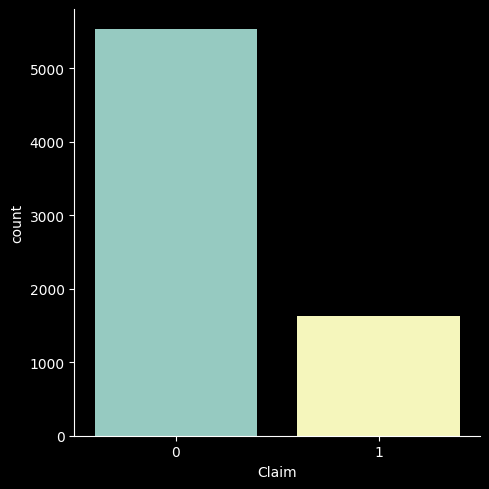

In [18]:
# explorons la distribution de la target
sns.catplot(data=train, x=TARGET, kind='count')
plt.show()

In [19]:
# Separating the dataset as per the two types of claims
train_0 = train[train['Claim'] == 0]
train_1 = train[train['Claim'] == 1]

### Compréhension des variables

In [21]:
variable_description

,Variable,Description
0,Customer Id,Identification number for the Policy holder
1,YearOfObservation,year of observation for the insured policy
2,Insured_Period,duration of insurance policy in Olusola Insura...
3,Residential,is the building a residential building or not
4,Building_Painted,"is the building painted or not (N-Painted, V-N..."
5,Building_Fenced,"is the building fence or not (N-Fenced, V-Not ..."
6,Garden,building has garden or not (V-has garden; O-no...
7,Settlement,Area where the building is located. (R- rural ...
8,Building Dimension,Size of the insured building in m2
9,Building_Type,"The type of building (Type 1, 2, 3, 4)"


Matrice de corrélation entre les variables

<Axes: title={'center': 'Corrélation des features'}>

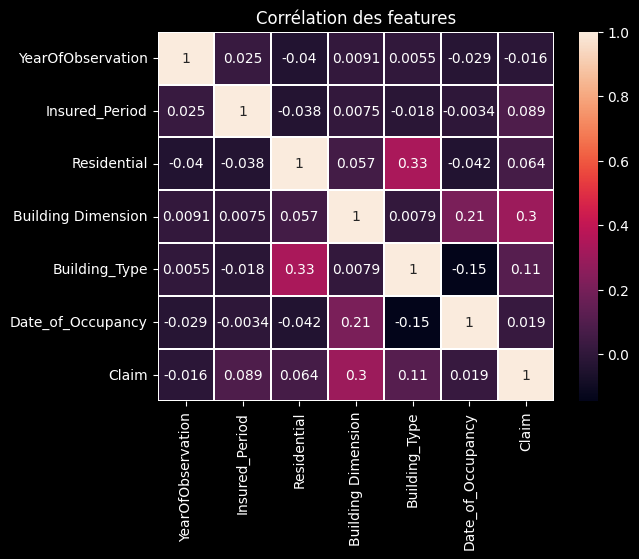

In [20]:
plt.title('Corrélation des features')
sns.heatmap(train.corr(numeric_only=True), linewidths=0.05, annot=True)

> 00 corrélation entre les variables du dataset

## Preprocessing

### Deleting missing values 

In [22]:
#We replace missing values for the building dimension and date of occupancy with Median since
#Both are highly skewed
train_full = train.copy()
train_full['Date_of_Occupancy'] = train_full['Date_of_Occupancy'].fillna(train_full['Date_of_Occupancy'].median())
train_full['Building Dimension'] = train_full['Building Dimension'].fillna(train_full['Building Dimension'].median())

#We replace the categorical variables with the mode
train_full['Garden'] = train_full['Garden'].fillna(train_full['Garden'].mode()[0])
train_full['Geo_Code'] = train_full['Geo_Code'].fillna(train_full['Geo_Code'].mode()[0])

In [23]:
#We replace missing values for the building dimension and date of occupancy with Median since
#Both are highly skewed
test_full = test.copy()
test_full['Date_of_Occupancy'] = test_full['Date_of_Occupancy'].fillna(test_full['Date_of_Occupancy'].median())
test_full['Building Dimension'] = test_full['Building Dimension'].fillna(test_full['Building Dimension'].median())

#We replace the categorical variables with the mode
test_full['Garden'] = test_full['Garden'].fillna(test_full['Garden'].mode()[0])
test_full['Geo_Code'] = test_full['Geo_Code'].fillna(test_full['Geo_Code'].mode()[0])

In [24]:
test_full.isnull().sum()

Customer Id           0
YearOfObservation     0
Insured_Period        0
Residential           0
Building_Painted      0
Building_Fenced       0
Garden                0
Settlement            0
Building Dimension    0
Building_Type         0
Date_of_Occupancy     0
NumberOfWindows       0
Geo_Code              0
dtype: int64

### Dummification

In [38]:
def preprocessing_data_1(data: pd.DataFrame, scaler) -> pd.DataFrame:
    ''' arrange un dataset
    '''
    # copie du dataset
    data1 = data.copy()
    # # arrangement de la colonne du nombre de fenêtres
    # data1['NumberOfWindows'] = data1['NumberOfWindows'].map(
    #     {'   .': 0, '>=10': 10}).fillna(data1['NumberOfWindows'])
    # data1['NumberOfWindows'] = data1['NumberOfWindows'].astype(int)
    # suppression de la variable d'identifiants uniques
    data1.drop(ID, axis=1, inplace=True)
    # la liste des colonnes discrètes
    object_columns = list(data1.select_dtypes(include='object').columns)
    # encodage des variables discrètes
    encoder = OrdinalEncoder()
    data1[object_columns] = encoder.fit_transform(data1[object_columns])
    # normalisation
    data1[data1.columns] = scaler.fit_transform(data1)
    return data1


def preprocessing_data_2(data: pd.DataFrame, scaler) -> pd.DataFrame:
    ''' Réalise la phase de pré-traitement d'un dataset à savoir l'encodage 
    des variables discrètes et la normalisation de toutes les variables 
    '''
    # copie du dataset
    data1 = data.copy()
    # arrangement de la colonne du nombre de fenêtres
    data1['NumberOfWindows'] = data1['NumberOfWindows'].map(
        {'   .': 0, '>=10': 10}).fillna(data1['NumberOfWindows'])
    data1['NumberOfWindows'] = data1['NumberOfWindows'].astype(int)
    # arrangement de la colonne du nombre de fenêtres
    data1['Geo_Code'] = data1['Geo_Code'].map(
        {'2A004': 20004, '2A090': 20090, '2A247': 20247, '2B033': 20033, '2B042': 20042, '2B050': 20050, '2B096': 20096, '2B353': 20353, '2B353': 20353}).fillna(data1['Geo_Code'])
    data1['Geo_Code'] = data1['Geo_Code'].astype(int)
    # suppression de la variable d'identifiants uniques
    data1.drop(ID, axis=1, inplace=True)
    data1 = pd.get_dummies(data1)
    # normalisation
    data1[data1.columns] = scaler.fit_transform(data1)
    return data1


def preprocessing_data_3(data: pd.DataFrame, scaler) -> pd.DataFrame:
    ''' Réalise la phase de pré-traitement d'un dataset à savoir l'encodage 
    des variables discrètes et la normalisation de toutes les variables 
    '''
    # copie du dataset
    data1 = data.copy()
    # suppression de la variable d'identifiants uniques
    data1.drop(ID, axis=1, inplace=True)
    # la liste des colonnes discrètes
    object_columns = list(data1.select_dtypes(include='object').columns)
    # encodage des variables discrètes
    encoder = OrdinalEncoder()
    data1[object_columns] = encoder.fit_transform(data1[object_columns])
    # normalisation
    data1[data1.columns] = scaler.fit_transform(data1)
    return data1


Instantiating the scalers

In [21]:
# Instantiating the scalers
MMS = MinMaxScaler()
MAS = MaxAbsScaler()
SS = StandardScaler()
RS = RobustScaler()

In [39]:
scaler = MMS

train_pp = preprocessing_data_3(train, scaler)
test_pp = preprocessing_data_3(test, scaler)

# train_full = preprocessing_data_1(train_full, scaler)
# test_full = preprocessing_data_1(test_full, scaler)

train_pp.head(3)

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,0.25,1.0,0.0,0.0,1.0,1.0,1.0,0.013802,0.0,0.881104,0.0,0.00536,0.0
1,0.75,1.0,0.0,1.0,0.0,0.0,0.0,0.023354,0.0,0.647558,0.4,0.00536,0.0
2,0.50,1.0,0.0,0.0,1.0,1.0,1.0,0.028368,0.0,0.881104,0.0,0.00536,0.0


In [40]:
test_pp.head(3)

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,0.25,1.000000,0.0,1.0,0.0,0.0,0.0,0.009725,0.0,0.801527,0.3,0.204023,0.0
1,1.00,0.997268,0.0,1.0,0.0,0.0,0.0,0.009725,0.0,0.801527,0.3,0.204023,0.0
2,0.25,0.369863,0.0,1.0,1.0,1.0,1.0,0.025664,0.0,0.801527,0.0,0.204023,0.0


In [97]:
train_full.head(3)

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,0.25,1.0,0.0,0.0,1.0,1.0,1.0,0.013802,0.0,0.881104,0.0,0.00536,0.0
1,0.75,1.0,0.0,1.0,0.0,0.0,0.0,0.023354,0.0,0.647558,0.4,0.00536,0.0
2,0.50,1.0,0.0,0.0,1.0,1.0,1.0,0.028368,0.0,0.881104,0.0,0.00536,0.0


## Modelling

### Splitting

In [41]:
X_train_pp = train_pp.drop([TARGET], axis=1)
y_train_pp = train_pp[TARGET]

In [42]:
X_Train, X_Val, y_Train, y_Val = train_test_split(X_train_pp, y_train_pp, test_size = 0.1, random_state=SEED)

In [116]:
X_train_full = train_full.drop([TARGET], axis=1)
y_train_full = train_full[TARGET]

X_train_full.head()

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code
0,0.25,1.0,0.0,0.0,1.0,1.0,1.0,0.013802,0.0,0.881104,0.0,0.00536
1,0.75,1.0,0.0,1.0,0.0,0.0,0.0,0.023354,0.0,0.647558,0.4,0.00536
2,0.50,1.0,0.0,0.0,1.0,1.0,1.0,0.028368,0.0,0.881104,0.0,0.00536
3,0.25,1.0,0.0,1.0,1.0,1.0,1.0,0.135584,0.0,0.881104,0.0,0.00536
4,0.50,1.0,0.0,1.0,0.0,0.0,0.0,0.032428,0.0,0.541401,0.3,0.00536


In [ ]:
X_Train_full, X_Val_full, y_Train_full, y_Val_full = train_test_split(X_train_full, y_train_full, test_size = 0.1, random_state=SEED)

### Entrainement du modèle avec CatBoost

In [43]:
params = {
    'n_estimators': 3000,
    'learning_rate': 0.1,
    'objective': 'Logloss',
    'eval_metric': 'AUC',
    'rsm': 0.7,
    'random_seed': SEED,
    'early_stopping_rounds': 300,
    'use_best_model': True,
}

In [101]:
model_lr = LogisticRegression()
model_lr.fit(X_Train_full, y_Train_full)

y_model_lr = model_lr.predict(X_Val_full)
fpr, tpr, thresholds = roc_curve(y_Val_full, y_model_lr, pos_label=1)
metrique = auc(fpr, tpr)

print(f"Taux d'erreur du {str(model_lr)} : {metrique}")

Taux d'erreur du LogisticRegression() : 0.5752068216481028


In [102]:
model_xgb = XGBClassifier()
model_xgb.fit(X_Train_full, y_Train_full)

y_model_xgb = model_xgb.predict(X_Val_full)
# metrique = 1 - accuracy_score(y_Val, y_model_xgb)
fpr, tpr, thresholds = roc_curve(y_Val_full, y_model_xgb, pos_label=1)
metrique = auc(fpr, tpr)

print(f"Taux d'erreur du {str(model_xgb)} : {metrique}")

Taux d'erreur du XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) : 0.6361787678513657


In [103]:
model_lgbm = LGBMClassifier()
model_lgbm.fit(X_Train_full, y_Train_full)

y_model_lgbm = model_lgbm.predict(X_Val_full)
fpr, tpr, thresholds = roc_curve(y_Val_full, y_model_lgbm, pos_label=1)
metrique = auc(fpr, tpr)

print(f"Taux d'erreur du {str(model_lgbm)} : {metrique}")

Taux d'erreur du LGBMClassifier() : 0.6058487775569626


In [44]:
model_cb = CatBoostClassifier(**params)
model_cb.fit(X_Train, y_Train, eval_set=[(X_Val, y_Val)], verbose=50)

y_model_cb = model_cb.predict(X_Val)
fpr, tpr, thresholds = roc_curve(y_Val, y_model_cb, pos_label=1)
metrique = auc(fpr, tpr)

print(f"Taux d'erreur du {str(model_cb)} : {metrique}")

0:	test: 0.7306235	best: 0.7306235 (0)	total: 5.77ms	remaining: 17.3s
50:	test: 0.7481340	best: 0.7573716 (2)	total: 173ms	remaining: 10s
100:	test: 0.7447255	best: 0.7573716 (2)	total: 341ms	remaining: 9.79s
150:	test: 0.7393238	best: 0.7573716 (2)	total: 506ms	remaining: 9.55s
200:	test: 0.7333387	best: 0.7573716 (2)	total: 693ms	remaining: 9.64s
250:	test: 0.7302537	best: 0.7573716 (2)	total: 864ms	remaining: 9.46s
300:	test: 0.7299995	best: 0.7573716 (2)	total: 1.04s	remaining: 9.35s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7573716319
bestIteration = 2

Shrink model to first 3 iterations.
Taux d'erreur du <catboost.core.CatBoostClassifier object at 0x000001E3E06A6860> : 0.5023570735314508


In [105]:
model_full = CatBoostClassifier(**params)
model_full.fit(X_Train_full, y_Train_full, eval_set=[(X_Val_full, y_Val_full)], verbose=50)

y_model_full = model_full.predict(X_Val_full)
fpr, tpr, thresholds = roc_curve(y_Val_full, y_model_full, pos_label=1)
metrique = auc(fpr, tpr)

print(f"Taux d'erreur du {str(model_full)} : {metrique}")

0:	test: 0.7050365	best: 0.7050365 (0)	total: 3.9ms	remaining: 11.7s
50:	test: 0.7475216	best: 0.7492894 (24)	total: 228ms	remaining: 13.2s
100:	test: 0.7428826	best: 0.7492894 (24)	total: 437ms	remaining: 12.5s
150:	test: 0.7476429	best: 0.7492894 (24)	total: 666ms	remaining: 12.6s
200:	test: 0.7473541	best: 0.7492894 (24)	total: 895ms	remaining: 12.5s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7492894117
bestIteration = 24

Shrink model to first 25 iterations.
Taux d'erreur du <catboost.core.CatBoostClassifier object at 0x000001F37D35AA40> : 0.578453574894856


Matrice de confusion

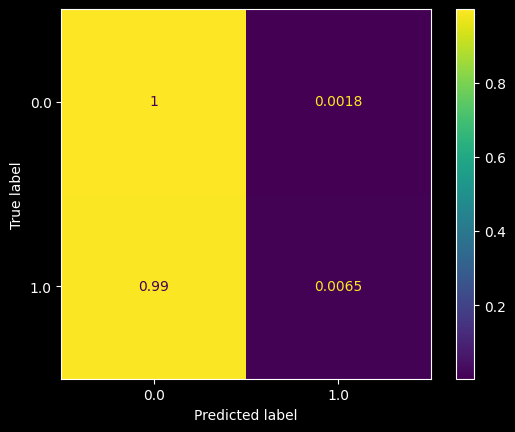

In [31]:
# traçons la matrice de confusion pour le modèle
ConfusionMatrixDisplay.from_estimator(model_cb, X_Val, y_Val, normalize='true')
plt.show()

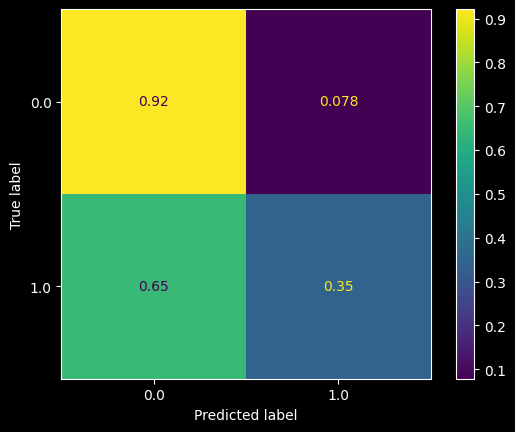

In [112]:
# traçons la matrice de confusion pour le modèle
ConfusionMatrixDisplay.from_estimator(model_xgb, X_Val_full, y_Val_full, normalize='true')
plt.show()

## Prediction

In [32]:
model = model_cb
# model = model_xgb
# model = model_lr
# model = model_lgbm

In [33]:
try:
	test_pp.drop(['Claim'], axis=1, inplace=True)
	# test_full.drop(['Claim'], axis=1, inplace=True)
except: pass

In [34]:
test[TARGET] = model.predict(test_pp)
# test[TARGET] = model.predict(test_full)
test.head(5)

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H11920,2013,1.000000,0,V,N,O,R,300.0,1,1960.0,3,3310,0.0
1,H11921,2016,0.997268,0,V,N,O,R,300.0,1,1960.0,3,3310,0.0
2,H9805,2013,0.369863,0,V,V,V,U,790.0,1,1960.0,.,3310,0.0
3,H7493,2014,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321,0.0
4,H7494,2016,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321,0.0


## Submission

Visualisation du fichier d'exemple de soumission

In [35]:
sample_submission.head()

,Customer Id,Claim
0,H0,1
1,H10000,1
2,H10001,1
3,H10002,1
4,H10003,1


Création de notre fichier de soumission

In [36]:
submissions = pd.DataFrame({ID: test[ID], TARGET: test[TARGET].astype(int)})
today = dt.now().strftime(format="%Y-%m-%d_%Hh%M")
submissions.to_csv(f'submissions/submission_{today}.csv', index=False)

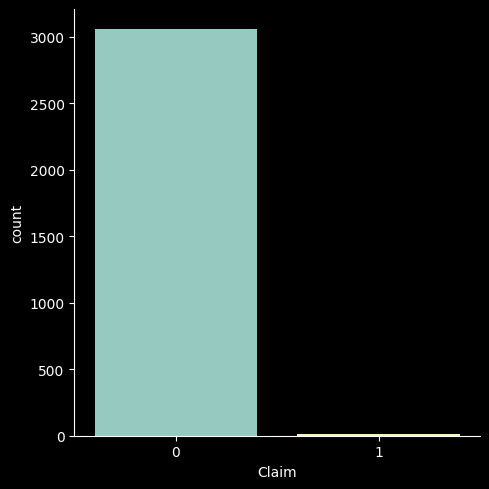

In [37]:
# explorons la distribution de la target
sns.catplot(data=submissions, x=TARGET, kind='count')
plt.show()

## Model saving

In [ ]:
# Save the model as a pickle in a file
file_name = 'basique_0.553050188'
joblib.dump(model, f'models/{file_name}.pkl')

['models/basique_0.553050188.pkl']